CS194-16 Introduction to Data Science

**Name**: *Tianzi Harrison*

**Student ID**: *4046501*


Assignment 2: Introduction to Machine Learning: Clustering and Regression
===

## Overview

In this assignment, we will use machine learning techniques to perform data analysis and learn models about our data. We will use a real world music dataset from [Last.fm](http://last.fm) for this assignment. There are two parts to this assignment: In the first part we will look at Unsupervised Learning with clustering and in the second part, we will study Supervised Learning. The play data (and user/artist matrix) comes from the [Last.fm 1K Users dataset](http://www.dtic.upf.edu/~ocelma/MusicRecommendationDataset/lastfm-1K.html), while the tags come from [the Last.fm Music Tags dataset](http://musicmachinery.com/2010/11/10/lastfm-artisttags2007/). You won't have to interact with these datasets directly, because we've already preprocessed them for you.

>**Note**: Before you begin, you should install pydot by running `sudo apt-get install python-pydot`. Additionally, you should be running on a VM with at least 1GB of RAM allotted to it - less than that and you may run into issues with scikit-learn.

### Introduction to Machine Learning

Machine learning is a branch of artifical intelligence where we try to find hidden structure within data. 
For example, lets say you are hired as a data scientist at a cool new music playing startup. You are given access to 
logs from the product and are asked find out what kinds of music are played on your website and how you can promote songs that will be 
popular. In this case we wish to extract some structure from the raw data we have using machine learning.

There are two main kinds of machine learning algorithms:

1. Unsupervised Learning - is the branch where we don't have any ground truth (or labeled data) that can help our training process. There are many approaches to unsupervised learning which includes topics like Clustering,  Mixture Models, Hidden Markov Models etc. In this assignment we will predominantly look at clustering.
2. Supervised Learning - we have training data which is labeled (either manually or from historical data) and we try to make predictions about those labels on new, unlabeled, data. There are similarly several approaches to supervised learning - various classification and regression techniques all the way up to Support Vector Machines and Convolutional Neural Networks. In this assignment we'll explore two regression algorithms - Least Squares Linear Regression and Regression Trees. 

Many of the techniques you'll be using (like testing on a validation set) are of critical importance to the modeling process, regardless of the technique you're using, so keep these in mind in your future modeling efforts.

### Application

Your assignment is to use machine learning algorithms for two tasks on a real world music dataset from Last.fm. The goal in the first part is to cluster artists and try to discover all artists that belong a certain genre. In the second part, we'll use the same dataset and attempt to predict how popular a song will be based on a number of features of that song. One component will involve incorporating cluster information into the models.

### Files

Data files for this assignment can be found at:

`https://github.com/amplab/datascience-sp14/raw/master/hw2/hw2data.tar.gz`

The zip file includes the following files:

* **artists-tags.txt**, User-defined tags for top artists
* **userart-mat-training.csv**, Training data containing a matrix mapping artist-id to users who have played songs by the artists
* **userart-mat-test.csv**, Test data containing a matrix mapping artist-id to users who have played songs by the artists
* **train_model_data.csv**, Aggregate statsitstics and features about songs we'll use to train regression models.
* **validation_model_data.csv**, Similar statistics computed on a hold-out set of users and songs that we'll use to validate our regression models.

We will explain the datasets and how they need to used in the assignment sections.

### Deliverables

Complete the all the exercises below and turn in a write up in the form of an IPython notebook, that is, **an .ipynb file**.
The write up should include your code, answers to exercise questions, and plots of results.
Complete submission instructions will be posted on Piazza.

We recommend that you do your work in a **copy of this notebook**, in case there are changes that need to be made that are pushed out via github. In this notebook, we provide code templates for many of the exercises. They are intended to help with code re-use, since the exercises build on each other, and are highly recommended. Don't forget to include answers to questions that ask for natural language responses, i.e., in English, not code!

### Guidelines

#### Code

This assignment can be done with basic python, matplotlib and scikit-learn.
Feel free to use Pandas, too, which you may find well suited to several exercises.
As for other libraries, please check with course staff whether they're allowed.

You're not required to do your coding in IPython, so feel free to use your favorite editor or IDE.
But when you're done, remember to put your code into a notebook for your write up.

#### Collaboration

This assignment is to be done individually.  Everyone should be getting a hands on experience in this course.  You are free to discuss course material with fellow students, and we encourage you to use Internet resources to aid your understanding, but the work you turn in, including all code and answers, must be your own work.

## Part 0: Preliminaries

### Exercise 0

Download the data and unzip it. 

Read in the file **artists-tags.txt** and store the contents in a DataFrame. The file format for this file is `artist-id|artist-name|tag|count`. The fields mean the following:

1. artist-id : a unique id for an artist (Formatted as a [MusicBrainz Identifier](https://musicbrainz.org/doc/MusicBrainz_Identifier))
2. artist-name: name of the artist
3. tag: user-defined tag for the artist
4. count: number of times the tag was applied

Similarly, read in the file **userart-mat-training.csv** . The file format for this file is `artist-id, user1, user2, .... user1000`. i.e. There are 846 such columns in this file and each column has a value 1 if the particular user played a song from this artist.

In [1]:
import pandas as pd
import numpy as np
import gzip
import sklearn
random = sklearn.base.np.random
random.seed(2015)

DATA_PATH = "C:/Anaconda/Viacom Python Class"

def parse_artists_tags(filename):
    df = pd.read_csv(filename, sep="|", names=["ArtistID", "ArtistName", "Tag", "Count"])
    return df

def parse_user_artists_matrix(filename):
    df = pd.read_csv(filename, sep = ",")
    return df

artists_tags = parse_artists_tags(DATA_PATH + "/artists-tags.txt")
user_art_mat = parse_user_artists_matrix(DATA_PATH + "/userart-mat-training.csv")

print ("Number of tags {}.".format(artists_tags.Tag.count()))
print ("Number of artists {}.".format(user_art_mat.ArtistID.count()))
# print "Number of tags %d" % 0 # Change this line. Should be 952803
# print "Number of artists %d" % 0 # Change this line. Should be 17119

Number of tags 952803.
Number of artists 17119.


In [2]:
artists_tags.head()

,ArtistID,ArtistName,Tag,Count
0,000077f7-26b1-4710-80cc-f6beddbdd157,Ryan Adams and The Cardinals,I love you baby can I have some more,1
1,000077f7-26b1-4710-80cc-f6beddbdd157,Ryan Adams and The Cardinals,alt country,2
2,000077f7-26b1-4710-80cc-f6beddbdd157,Ryan Adams and The Cardinals,whoa,1
3,00034ede-a1f1-4219-be39-02f36853373e,O Rappa,Artist,1
4,00034ede-a1f1-4219-be39-02f36853373e,O Rappa,Black,1


In [3]:
user_art_mat.head()

,ArtistID,user_000001,user_000002,user_000003,user_000004,user_000005,user_000006,user_000007,user_000008,user_000009,...,user_000890,user_000891,user_000892,user_000893,user_000894,user_000895,user_000896,user_000897,user_000898,user_000899
0,c489cd1c-d8d3-4dcc-b7b9-dcf7cd95d2ed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9ccbb935-33fd-4df8-ae2d-779497c5630a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,c71b2cc1-2737-4f76-bbf2-9ee505b4d90d,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0aa8294b-6332-4b65-b677-e3a1f8591d3b,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,67673557-2310-41d3-83b9-e6e0cb1d65d5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
len(artists_tags.ArtistID.unique())

20907

## Part 1: Finding genres by clustering

The first task we will look at is how to discover artist genres by only looking at data from plays on Last.fm. One of the ways to do this is to use clustering. To evaluate how well our clustering algorithm performs we will use the user-generated tags and compare those to our clustering results. 

### 1.1 Data pre-processing

Last.fm allows users to associate tags with every artist (See the [top tags](http://www.last.fm/charts/toptags) for a live example). However as there are a number of tags associated with every artists, in the first step we will pre-process the data and get the most popular tag for an artist.

#### Exercise 1

**a**. For every artist in **artists_tags** calculate the most frequently used tag. 

In [5]:
# TODO Implement this. You can change the function arguments if necessary
# Return a data structure that contains (artist id, artist name, top tag) for every artist
def calculate_top_tag(all_tags):
    grouped = all_tags.sort('Count', ascending = False).groupby(by = 'ArtistID').head(1)
    return grouped

top_tags = calculate_top_tag(artists_tags)

# Print the top tag for Nirvana
# Artist ID for Nirvana is 5b11f4ce-a62d-471e-81fc-a69a8278c7da
# Should be 'Grunge'

irow = top_tags[top_tags.ArtistName == 'Nirvana'].index.tolist()

print ("Top tag for Nirvana is {}.".format(top_tags.loc[irow[0], 'Tag']))

Top tag for Nirvana is Grunge.


**b**. To do clustering we will be using `numpy` matrices. Create a matrix from **user_art_mat** with every row in the matrix representing a single artist. The matrix will have 846 columns, one for whether each user listened to the artist.

In [6]:
def create_user_matrix(input_data):
    
    #input_data.index = input_data.values[:, 0]
    new_matrix = input_data.values[:, 1:]
    
    # -------------------------------------------------  Method 2: 
    # n = len(input_data.columns)
    # new_matrix = input_data.ix[:, 1:n].as_matrix(columns = None)
    # ------------------------------------------------------------
    
    return new_matrix

user_np_matrix = create_user_matrix(user_art_mat)
print (user_np_matrix.shape)
print(user_np_matrix)
# print user_np_matrix.shape # Should be (17119, 846)

(17119, 846)
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


### 1.2 K-Means clustering

Having pre-processed the data we can now perform clustering on the dataset. In this assignment we will be using the python library 
[scikit-learn](http://scikit-learn.org/stable/index.html) for our machine learning algorithms. scikit-learn provides an extensive
library of machine learning algorithms that can be used for analysis. Here is a [nice flow chart](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) that shows various algorithms implemented
and when to use any of them. In this part of the assignment we will look at K-Means clustering

> **Note on terminology**: "samples" and "features" are two words you will come across frequently when you look at machine learning papers or documentation. "samples" refer to data points that are used as inputs to the machine learning algorithm. For example in our dataset each artist is a "sample". "features" refers to some representation we have for every sample. For example the list of 1s and 0s we have for each artist are "features". Similarly the bag-of-words approach from the previous homework produced "features" for each document.

#### K-Means algorithm

Clustering is the process of automatically grouping data points that are similar to each other. In the [K-Means algorithm](http://en.wikipedia.org/wiki/K-means_clustering) we start with `K` initially chosen cluster centers (or centroids). We then compute the distance of every point from the centroids and assign each point to the centroid. Next we update the centroids by averaging all the points in the cluster. Finally, we repeat the algorithm until the cluster centers are stable.

### Running K-Means

#### K-Means interface
Take a minute to look at the scikit-learn interface for calling [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). The constructor of the KMeans class returns a `estimator` on which you can call [fit](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit) to perform clustering.

#### K-Means parameters
From the above description we can see that there are a few parameters which control the K-Means algorithm. We will look at one parameter specifically, the number of clusters used in the algorithm. The number of clusters needs to be chosen based on domain knowledge of the data. As we do not know how many genres exist we will try different values and compare the results.

#### Timing your code
We will also measure the performance of clustering algorithms in this section. You can time the code in a cell using the **%%time** [IPython magic](http://nbviewer.ipython.org/github/ipython/ipython/blob/1.x/examples/notebooks/Cell%20Magics.ipynb) as the first line in the cell. 

>**Note**: By default, the scikit-learn KMeans implementation runs the algorithm 10 times with different center initializations. For this assignment you can run it just once by passing the `n_init` argument as 1.

#### Exercise 2

**a**. Run K-means using *5* cluster centers on the `user_np_matrix`.

In [10]:
%%time
from sklearn.cluster import KMeans
random.seed(2015)
#sklearn.cluster.KMeans
# Run K-means using 5 cluster centers on user_np_matrix

model_5 = KMeans(n_clusters = 5, n_init = 1)
kmeans_5 = model_5.fit(user_np_matrix)

Wall time: 6.54 s


**b**. Run K-means using *25* and *50* cluster centers on the `user_np_matrix`. Also measure the time taken for both cases.

In [11]:
%%time
random.seed(2015)
model_25 = KMeans(n_clusters = 25, n_init = 1)
kmeans_25 = model_25.fit(user_np_matrix)

Wall time: 17 s


In [12]:
%%time
random.seed(2015)
model_50 = KMeans(n_clusters = 50, n_init = 1)
kmeans_50 = model_50.fit(user_np_matrix)

Wall time: 8.92 s


**d**. Of the three algorithms, which setting took the longest to run ? Why do you think this is the case ?

>K-means with 50 cluster centers took the longest to run. I guess there is simply more calculations involved.

### 1.3 Evaluating K-Means

In addition to the performance comparisons we also wish to compare how good our clusters are. To do this we are first going to look at internal evaluation metrics. For internal evaluation we only use the input data and the clusters created and try to measure the quality of clusters created. We are going to use two metrics for this:

#### Inertia
Inertia is a metric that is used to estimate how close the data points in a cluster are. This is calculated as the sum of squared distance for each point to it's closest centroid, i.e., its assigned cluster center. The intution behind inertia is that clusters with lower inertia are better as it means closely related points form a cluster.Inertia is calculated by scikit-learn by default.


**Exercise 3**

**a**. Print inertia for all the kmeans model computed above.

In [13]:
print ("Inertia for KMeans with 5 clusters = {}".format(kmeans_5.inertia_))
print ("Inertia for KMeans with 25 clusters = {}".format(kmeans_25.inertia_))
print ("Inertia for KMeans with 50 clusters = {}".format(kmeans_50.inertia_))

Inertia for KMeans with 5 clusters = 349854.4952784411
Inertia for KMeans with 25 clusters = 321519.7873142422
Inertia for KMeans with 50 clusters = 310445.6586311454


**b**. Does KMeans run with 25 clusters have lower or greater inertia than the ones with 5 clusters ? Which algorithm is better and why ?

> KMeans run with 25 clusters have lower inertia than the ones with 5 clusters. KMeans with 50 is better because the distance is the smallest. 

#### Silhouette Score: 
The silhouette score measures how close various clusters created are. A higher silhouette score is better as it means that we dont have too many overlapping clusters. The silhouette score can be computed using [sklearn.metrics.silhouette_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) from scikit learn.

**c.** Calculate the Silhouette Score using 500 sample points for all the kmeans models.

In [14]:
from sklearn.metrics import silhouette_score
random.seed(2015)

# NOTE: Use 500 sample points to calculate the silhouette score
def get_silhouette_score(data, model):
    predicted_labels = model.fit_predict(data)
    score = silhouette_score(X = data, labels = predicted_labels, sample_size = 500)
    return score

print ("Silhouette Score for KMeans with 5 clusters = {}".format(get_silhouette_score(user_np_matrix, model_5)))
print ("Silhouette Score for KMeans with 25 clusters = {}".format(get_silhouette_score(user_np_matrix, model_25)))
print ("Silhouette Score for KMeans with 50 clusters = {}".format(get_silhouette_score(user_np_matrix, model_50)))

Silhouette Score for KMeans with 5 clusters = 0.27290265608841174
Silhouette Score for KMeans with 25 clusters = 0.08515288071927353
Silhouette Score for KMeans with 50 clusters = 0.030044564016016972


C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


**d**. How does increasing the number of clusters affect the silhouette score ?

> Silhouette scores run from -1 to 1. Negative scores indicate wrong cluster assignments for some data points. o indicates overlapping clusters. When the number of clusters increases, the silhouette score decreases, suggesting a less good model fit. 

### 1.4 External Evaluation
While internal evaluation is useful, a better method for measuring clustering quality is to do external evaluation. This might not be possible always as we may not have ground truth data available. In our application we will use `top_tags` from before as our ground truth data for external evaluation. We will first compute purity and accuracy and finally we will predict tags for our **test** dataset.

#### Exercise 4

**a**. As a first step we will need to **join** the `artist_tags` data with the set of labels generated by K-Means model. That is, for every artist we will now have the top tag, cluster id and artist name in a data structure.

In [15]:
random.seed(2015)
# Return a data structure that contains artist_id, artist_name, top tag, cluster_label for every artist
def join_tags_labels(artists_data, user_data, kmeans_model):
    user_mat = create_user_matrix(user_data)
    cluster_df = pd.DataFrame([user_data.values[:,0], kmeans_model.fit_predict(user_mat)], index = ['ArtistID', 'ClusterID']).T
    result = pd.merge(left = artists_data, right = cluster_df, on = 'ArtistID', how = 'left')
    return result

# Run the function for all the models
kmeans_5_joined = join_tags_labels(top_tags, user_art_mat, model_5)
kmeans_25_joined = join_tags_labels(top_tags, user_art_mat, model_25)
kmeans_50_joined = join_tags_labels(top_tags, user_art_mat, model_50)

# model_5.fit_predict(user_np_matrix) # returns an array

In [16]:
kmeans_5_joined.head()

,ArtistID,ArtistName,Tag,Count,ClusterID
0,5b11f4ce-a62d-471e-81fc-a69a8278c7da,Nirvana,Grunge,5713,2
1,8bfac288-ccc5-448d-9573-c33ea2aa5c30,Red Hot Chili Peppers,rock,5476,2
2,0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,Death Cab for Cutie,indie,4703,2
3,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,alternative,4685,2
4,65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab,Metallica,metal,4637,2


In [17]:
kmeans_25_joined.head()

,ArtistID,ArtistName,Tag,Count,ClusterID
0,5b11f4ce-a62d-471e-81fc-a69a8278c7da,Nirvana,Grunge,5713,1
1,8bfac288-ccc5-448d-9573-c33ea2aa5c30,Red Hot Chili Peppers,rock,5476,1
2,0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,Death Cab for Cutie,indie,4703,1
3,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,alternative,4685,1
4,65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab,Metallica,metal,4637,24


In [18]:
kmeans_50_joined.head()

,ArtistID,ArtistName,Tag,Count,ClusterID
0,5b11f4ce-a62d-471e-81fc-a69a8278c7da,Nirvana,Grunge,5713,40
1,8bfac288-ccc5-448d-9573-c33ea2aa5c30,Red Hot Chili Peppers,rock,5476,40
2,0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,Death Cab for Cutie,indie,4703,6
3,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,alternative,4685,28
4,65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab,Metallica,metal,4637,35


**b**. Next we need to generate a genre for every cluster id we have (the cluster ids are from 0 to N-1). You can do this by **grouping** the data from the previous exercise on cluster id. 

One thing you might notice is that we typically get a bunch of different tags associated with every cluster. How do we pick one genre or tag from this ? To cover various tags that are part of the cluster, we will pick the **top 5** tags in each cluster and save the list of top-5 tags as the genre for the cluster.


In [19]:
# Return a data structure that contains cluster_id, list of top 5 tags for every cluster
def assign_cluster_tags(joined_data):
    n = joined_data.ClusterID.max() + 1
    grp1 = joined_data.dropna(axis=0, how='any')[['Tag', 'ClusterID', 'Count']].groupby(by = ['ClusterID', 'Tag']).count()
    grp2 = grp1['Count'].groupby(level=0, group_keys=False).apply(lambda x: x.order(ascending = False).head(n))
    return grp2
    
kmeans_5_genres = assign_cluster_tags(kmeans_5_joined)
kmeans_25_genres = assign_cluster_tags(kmeans_25_joined)
kmeans_50_genres = assign_cluster_tags(kmeans_50_joined)

In [20]:
kmeans_5_genres

ClusterID  Tag         
0          seen live       368
           rock            240
           indie           223
           hardcore        169
           Hip-Hop         166
1          indie           136
           electronic       55
           Hip-Hop          16
           rock             16
           seen live        14
2          indie            57
           rock             34
           electronic       18
           classic rock     11
           britpop           7
3          indie           153
           electronic      143
           jazz            123
           seen live       102
           Hip-Hop         100
4          rock             98
           pop              69
           classic rock     36
           80s              18
           emo              17
dtype: int64

#### Purity and Accuracy
Two commonly used metrics used for evaluating clustering using external labels are purity and accuracy. **Purity** measures the frequency of data belonging to the same cluster sharing the same class label i.e. if we have a number of items in a cluster how many of those items have the same label ? Meanwhile, **accuracy** measures the frequency of data from the same class appearing in a single cluster i.e. of all the items which have a particular label what fraction appear in the same cluster ?

>NOTE: This is similar to precision and recall that we looked at in the previous assignment. Purity here makes sure that our clusters have mostly homogeneous labels while accuracy make sure that our labels are not spread out over too many clusters.

**d**. Compute the purity for each of our K-Means models. To do this find the top tags of all artists that belong to a cluster. Check what fraction of these tags are covered by the top 5 tags of the cluster. Average this value across all clusters. **HINT**: We used similar ideas to get the top 5 tags in a cluster. 

In [21]:
def get_cluster_purity(joined_data):
    n = joined_data.ClusterID.max() + 1
    grp1 = joined_data.dropna()[['Tag', 'ClusterID', 'Count']].groupby(by = ['ClusterID', 'Tag']).count()
    grp2 = grp1['Count'].groupby(level=0).apply(lambda x: x.order(ascending = False))
    p = []
    for i in range(n): 
        p.append(grp2[i][:5].sum()/grp2[i].sum())
    result = np.array(p).mean()
    return result
    
print ("Purity for KMeans with 5 centers {}".format(get_cluster_purity(kmeans_5_joined)))
print ("Purity for KMeans with 25 centers {}".format(get_cluster_purity(kmeans_25_joined)))
print ("Purity for KMeans with 50 centers {}".format(get_cluster_purity(kmeans_50_joined)))

Purity for KMeans with 5 centers 0.41224566570932614
Purity for KMeans with 25 centers 0.6598413973958007
Purity for KMeans with 50 centers 0.7875151777663241


**e**. To compute the accuracy first get all the unique tags from *top_tags*. Then for each tag, compute how many artists are found in the largest cluster. We denote these as correct cluster assignments. For example, lets take a tag 'rock'. If there are 100 artists with tag 'rock' and say 90 of them are in one cluster while 10 of them are in another. Then we have 90 correct cluster assignments

Add the number of correct cluster assignments for all tags and divide this by the total size of the training data to get the accuracy for a model.

In [22]:
def get_accuracy(joined_data):
    grp1 = joined_data.dropna()[['Tag', 'ClusterID', 'Count']].groupby(by = ['Tag', 'ClusterID']).count()
    grp2 = grp1['Count'].groupby(level = 0, group_keys = False).apply(lambda x: (x/x.sum()).order(ascending = False).head(1))
    return grp2.mean()
    
print("Accuracy of KMeans with 5 centers {}".format(get_accuracy(kmeans_5_joined)))
print("Accuracy of KMeans with 25 centers {}".format(get_accuracy(kmeans_25_joined)))
print("Accuracy of KMeans with 50 centers {}".format(get_accuracy(kmeans_50_joined)))

Accuracy of KMeans with 5 centers 0.8673000528156332
Accuracy of KMeans with 25 centers 0.797256807331635
Accuracy of KMeans with 50 centers 0.7781629551079572


In [23]:
# reference:
print('Does kmeans_5_joined have the same number of rows as top_tags? \n{}\n'.format(len(kmeans_5_joined) == len(top_tags)))
test = kmeans_5_joined.dropna(axis = 0, how = 'any')[['Tag', 'ClusterID', 'Count']]
x = test.groupby(by = ['Tag', 'ClusterID']).count()
print('Data grouped by Tag and Cluster ID: \n{}\n'.format(x[:10]))
grp2 = x['Count'].groupby(level=0, group_keys=False).apply(lambda x: (x/x.sum()).order(ascending = False).head(1))
print("Data grouped by Tag and ClusterID: \n{}\n".format(grp2[:10]))
print('The accuracy score is {}'.format(grp2.mean()))

Does kmeans_5_joined have the same number of rows as top_tags? 
True

Data grouped by Tag and Cluster ID: 
                 Count
Tag   ClusterID       
00s   0              1
4ad   0              1
      3              2
50s   0              2
60s   0              4
      3              4
70s   0              1
8-bit 0              3
80s   0             29
      1              2

Data grouped by Tag and ClusterID: 
Tag             ClusterID
00s             0            1.000000
4ad             3            0.666667
50s             0            1.000000
60s             3            0.500000
70s             0            1.000000
8-bit           0            1.000000
80s             0            0.376623
80s influenced  0            1.000000
8bit            0            1.000000
90s             3            1.000000
dtype: float64

The accuracy score is 0.8673000528156332


**f.** What do the numbers tell you about the models? Do you have a favorite?

>TODO: My favorite is the one with 5 clusters. It's the most accurate, although it's not pure. 

### 1.5 Evaluating Test Data
Finally we can treat the clustering model as a multi-class classifier and make predictions on external test data. To do this we load the test data file **userart-mat-test.csv** and for every artist in the file we use the K-Means model to predict a cluster. We mark our prediction as successful if the artist's top tag belongs to one of the five tags for the cluster. 

#### Exercise 5

**a** Load the testdata file and create a NumPy matrix named user_np_matrix_test.

In [24]:
user_art_mat_test = parse_user_artists_matrix(DATA_PATH + "/userart-mat-test.csv")
# NOTE: the astype(float) converts integer to floats here
user_np_matrix_test = create_user_matrix(user_art_mat_test).astype(float)

user_np_matrix_test.shape # Should be (1902, 846)

(1902, 846)

**b.** For each artist in the test set, call **[predict](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.predict)** to get the predicted cluster. Join the predicted labels with test artist ids. Return 'artist_id', 'predicted_label' for every artist in the test dataset.

In [25]:
# For every artist return a list of labels
random.seed(2015)
def predict_cluster(test_data, test_np_matrix, kmeans_model):
    predicted_test = pd.DataFrame([test_data.values[:,0], kmeans_model.fit_predict(user_np_matrix)], 
                              index = ['ArtistID', 'ClusterID']).T
    return predicted_test

# Call the function for every model from before
kmeans_5_predicted = predict_cluster(user_art_mat_test, user_np_matrix_test, model_5)
kmeans_25_predicted = predict_cluster(user_art_mat_test, user_np_matrix_test, model_25)
kmeans_50_predicted = predict_cluster(user_art_mat_test, user_np_matrix_test, model_50)

In [26]:
print(kmeans_5_predicted[:3])
print(kmeans_25_predicted[:3])
print(kmeans_50_predicted[:3])

                               ArtistID ClusterID
0  675b7627-6b5d-4a46-a728-785cb24a299e         0
1  07b6020a-c539-4d68-aeef-f159f3befc76         0
2  14dbdcb4-dbc1-49dc-b950-6815b06c13cf         0
                               ArtistID ClusterID
0  675b7627-6b5d-4a46-a728-785cb24a299e         5
1  07b6020a-c539-4d68-aeef-f159f3befc76        23
2  14dbdcb4-dbc1-49dc-b950-6815b06c13cf        23
                               ArtistID ClusterID
0  675b7627-6b5d-4a46-a728-785cb24a299e        38
1  07b6020a-c539-4d68-aeef-f159f3befc76         2
2  14dbdcb4-dbc1-49dc-b950-6815b06c13cf         2


**c**. Get the tags for the predicted genre and the tag for the artist from `top_tags`. Output the percentage of artists for whom the top tag is one of the five that describe its cluster. This is the *recall* of our model.
>NOTE: Since the tag data is not from the same source as user plays, there are artists in the test set for whom we do not have top tags. You should exclude these artists while making predictions and while computing the recall.

In [27]:
# Calculate recall for our predictions
def verify_predictions(predicted_artist_labels, cluster_genres, top_tag_data):
    p = 0
    n = len(cluster_genres.index.get_level_values(0).unique())
    temp = pd.merge(predicted_artist_labels, top_tag_data, on = 'ArtistID', 
                    how = 'left').dropna()[['ArtistID', 'ClusterID', 'Tag']]
    
    for i in range(n):
        x = temp[(temp.ClusterID == i)].Tag.apply(lambda x: sum(pd.Series(cluster_genres.index.get_loc_level(i)[1]==x)))
        p = p + sum(x)
    
    result = p/len(temp)
    return result

#temp = pd.merge(kmeans_5_predicted, top_tags, on = 'ArtistID', how = 'left').dropna()[['ArtistID', 'ClusterID', 'Tag']]
#print(kmeans_5_genres.index.get_loc_level(0))
#print(temp[:6])
#print (len(temp))
#print(len(kmeans_50_genres.index.get_level_values(0).unique()))
#i = 2
#x = temp[(temp.ClusterID == i)].Tag.apply(lambda x: sum(pd.Series(kmeans_5_genres.index.get_loc_level(i)[1]==x)))
#print(sum(x))

**d**. Print the recall for each KMeans model. We define recall as num_correct_predictions / num_artists_in_test_data

In [28]:
# Use verify_predictions for every model
print ("Recall of KMeans with 5 centers: {}".format(verify_predictions(kmeans_5_predicted, kmeans_5_genres, top_tags)))
print ("Recall of KMeans with 25 centers: {}".format(verify_predictions(kmeans_25_predicted, kmeans_25_genres, top_tags)))
print ("Recall of KMeans with 50 centers: {}".format(verify_predictions(kmeans_50_predicted, kmeans_50_genres, top_tags)))

Recall of KMeans with 5 centers: 0.1939275220372184
Recall of KMeans with 25 centers: 0.38883447600391774
Recall of KMeans with 50 centers: 0.47600391772771794


### 1.6 Visualizing Clusters using PCA

Another way to evaluate clustering is to visualize the output of clustering. However the data we are working with is in 846 dimensions !, so it is hard to visualize or plot this. Thus the first step for visualization is to reduce the dimensionality of the data. To do this we can use [Prinicipal Component Analysis (PCA)](http://en.wikipedia.org/wiki/Principal_component_analysis). PCA reduces the dimension of data and keeps only the most significant components of it. This is a commonly used technique to visualize data from high dimensional spaces.

>**NOTE**: We use [RandomizedPCA](http://scikit-learn.org/stable/modules/decomposition.html#approximate-pca), an approximate version of the algorithm as this has lower memory requirements. The approximate version is good enough when we are reducing to a few dimensions (2 in this case). We also sample the input data before PCA to further reduce memory requirements.

#### Exercise 6

**a**. Calcluate the RandomizedPCA of the sampled training data set `sampled_data` and reduce it to 2 components. Use the [fit_transform](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.RandomizedPCA.html#sklearn.decomposition.RandomizedPCA.fit_transform) method to do this.

In [29]:
from sklearn.decomposition import RandomizedPCA

sample_percent = 0.20
rows_to_sample = int(np.ceil(sample_percent * user_np_matrix.shape[0]))
print("rows_to_sample is: {}\n".format(rows_to_sample))

sampled_data = user_art_mat.values[np.random.choice(user_art_mat.shape[0], rows_to_sample, replace=False),:]

# Return the data reduced to 2 principal components
def get_reduced_data(input_data):
    pca = RandomizedPCA(n_components=2)
    output = pca.fit_transform(input_data[:, 1:])
    return output

user_np_2d = get_reduced_data(sampled_data)
print('user_np_2d shape: {}\n'.format(user_np_2d.shape))
print('user_np_2d type: {}\n'.format(type(user_np_2d)))
print(user_np_2d)

rows_to_sample is: 3424

user_np_2d shape: (3424, 2)

user_np_2d type: <class 'numpy.ndarray'>

[[ 1.58567224 -0.21871501]
 [-0.57097488  0.98825857]
 [ 2.21482553  0.17395321]
 ..., 
 [-1.01388243 -0.24458226]
 [ 0.21157245 -0.48180887]
 [-0.17131547  0.77105484]]


**b**. Fit the reduced data with the KMeans model with 5 cluster centers. Plot the cluster centers and all the points. Make sure to color points in every cluster differently to see a visual separation. You may find [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter) and [`plot`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot) functions from matplotlib to be useful.


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


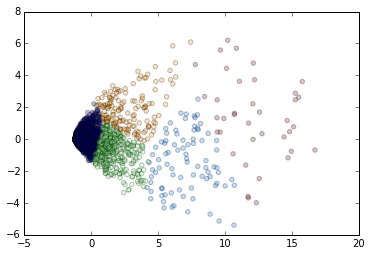

In [30]:
# TODO: Write code to fit and plot reduced_data.
import pylab as pl
%pylab inline

colors = model_5.fit_predict(user_np_2d)
pl.scatter(x = user_np_2d.T[0], y = user_np_2d.T[1], c=colors, alpha=0.25)
pl.show()


# Part 2 - Regression Models - Predicting Song Popularity

In this section of the assignment you'll be building a model to predict the number of plays a song will get. Again, we're going to be using scikit-learn to train and evaluate regression models, and pandas to pre-process the data.

In the process, you'll encounter some modeling challenges and we'll look at how to deal with them.

We've started with the same data as above, but this time we've pre-computed a number of song statistics for you.

These are:

1. plays - the number of times a song has been played.
1. pctmale - percentage of the plays that came from users who self-identified as "male".
1. age - average age of the listener.
1. country1 - the country of the users that listened to this song most.
1. country2 - the country of the users that listened to this song second most.
1. country3 - the country of the users that listened to this song third most.
1. pctgt1 - Percentage of plays that come from a user who's played the song more than once.
1. pctgt2 - Percentage of plays that come from a user who's played the song more than twice.
1. pctgt5 - Percentage of plays that come from a user who's played the song more than five times.
1. cluster - The "cluster number" of the artist associated with this song - similar to what you came up with above. We chose 25 clusters fairly arbitrarily.

### 2.1 Data Exploration
#### Exercise 7

**a**. Let's start by loading up the data - we've provided a "training set" and a "validation set" for you to test your models on. The training set are the examples that we use to create our models, while the validation set is a dataset we "hold out" from the model fitting process, we use these examples to test whether our models accurately predict new data.


In [31]:
import pandas as pd
%pylab inline


train = pd.read_csv(DATA_PATH + "/train_model_data.csv")
validation = pd.read_csv(DATA_PATH + "/validation_model_data.csv")

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Now that you've got the data loaded, play around with it, generate some descriptive statistics, and get a feel for what's in the data set. For the categorical variables try pandas ".count_values()" on them to get a sense of the most likely distributions (countries, etc.). 

**b**. In the next cell put some commands you ran to get a feel for the data.

In [32]:
# TODO: Your commands for data exploration here.
print("train shape: {}\ntrain:\n{}\n".format(train.shape, train[:3]))
print("validation shape: {}\nvalidation: \n{}".format(validation.shape, validation[:3]))

train shape: (108537, 13)
train:
                                  artid  \
0  0004537a-4b12-43eb-a023-04009e738d2e   
1  0004537a-4b12-43eb-a023-04009e738d2e   
2  0004537a-4b12-43eb-a023-04009e738d2e   

                                                 key  plays   pctmale  \
0  0004537a-4b12-43eb-a023-04009e738d2e 66688680-...     51  1.000000   
1  0004537a-4b12-43eb-a023-04009e738d2e e427fb6c-...     41  1.000000   
2  0004537a-4b12-43eb-a023-04009e738d2e d02a5cc2-...    183  0.983607   

         age       country1        country2 country3  pctgt1  pctgt2  pctgt5  \
0  25.000000  United States             NaN      NaN       1     1.0     1.0   
1        NaN  United States             NaN      NaN       1     0.5     0.5   
2  29.290123  United States  Czech Republic      NaN       1     1.0     0.6   

   account_age  cluster  
0   622.411765        5  
1   114.048780        5  
2   610.677596        5  

validation shape: (25573, 13)
validation: 
                                

**c**. Next, create a pairwise scatter plot of the columns: plays, pctmale, age, pctgt1, pctgt2, pctgt5. (_Hint: we did this in lab!_)

Do you notice anything about the data in this view? What about the relationship between plays and other columns?

pairwise scatter matrix:



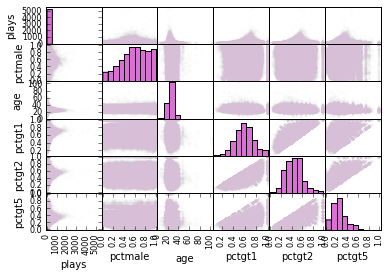

In [162]:
# TODO: Your commands to generate a scatter plot here.

#sample_percent = 0.20
#rows_to_sample2 = int(np.ceil(sample_percent * train.shape[0]))
train_ok = train.dropna()
#sampled_data2 = train_ok.values[np.random.choice(train_ok.shape[0], rows_to_sample2, replace=False),:]

from pandas.tools.plotting import scatter_matrix

#df = pd.DataFrame(sampled_data2[:, array([2,3,4,8,9,10])].tolist(), 
#                    columns = ['plays', 'pctmale', 'age', 'pctgt1', 'pctgt2', 'pctgt5'])
df_all = pd.DataFrame(train_ok[['plays', 'pctmale', 'age', 'pctgt1', 'pctgt2', 'pctgt5']])

scatter_matrix(df_all, alpha=0.01, hist_kwds={'color':['orchid']}, color = 'thistle')
print("pairwise scatter matrix:\n")
scatter_matrix?

>TODO: There may be a linear relationship between plays and some other variables.

###2.2 Data Prep and Intro to Linear Regression

*scikit-learn* does a number of things very well, but one of the things it doesn't handle easily is categorical or missing data. Categorical data is data that can take on a finite set of values, e.g. a categorical variable might be the color of a stop light (Red, Yellow, Green), this is in contrast with continuous variables like real numbers in the range -Infinity to +Infinity. There is another common type of data called "ordinal" that can be thought of as categorical data that has a natural ordering, like: Cold, Warm, Hot. We won't be dealing with this kind of data here, but having that kind of ranking opens up the use of certain other statistical methods.


#### Exercise 8

**a**. For the first part of the exercise, let's eliminate categorical variables, and *impute* missing values with pandas. Write a function to drop all categorical variables from the data set, and return two pandas data frames:

1. A data frame with all categorical items and a user-specified response column removed.
2. A data frame that contains only the response column.

In [75]:
def basic_prep(data, col):
    #TODO - make a copy of the original dataset but with the categorical variables removed! *Cluster* should be thought of as a 
    #categorical variable and should be removed! Make use of pandas ".drop" function.
    
    li = ['artid', 'key', 'country1', 'country2', 'country3', 'cluster']
    li.append(col)
    li = list(set(li))
    basic_features = data.drop(li, axis = 1)
    basic_features = basic_features.fillna(basic_features.mean(), axis = 0)
    
    #TODO - impute missing values with the mean of those columns, use pandas ".fillna" function to accomplish this.
    response = data[col].to_frame(name = col).fillna(data[col].mean())
    
    return basic_features, response

#This will create two new data frames, one that contains training data - in this case all the numeric columns,
#and one that contains response data - in this case, the "plays" column.
train_basic_features, train_basic_response = basic_prep(train, 'plays')
validation_basic_features, validation_basic_response = basic_prep(validation, 'plays')
print(type(train_basic_features))
print(train_basic_features[:3])
print(type(train_basic_response))
print(train_basic_response[:3])

<class 'pandas.core.frame.DataFrame'>
    pctmale        age  pctgt1  pctgt2  pctgt5  account_age
0  1.000000  25.000000       1     1.0     1.0   622.411765
1  1.000000  25.719383       1     0.5     0.5   114.048780
2  0.983607  29.290123       1     1.0     0.6   610.677596
<class 'pandas.core.frame.DataFrame'>
   plays
0     51
1     41
2    183


Now, we're going to train a linear regression model. This is likely the most widely used model for fitting data out there today - you've probably seen it before, maybe even used it in Excel. The goal of linear modeling, is to fit a **linear equation** that maps a set of **input features** to a numerical **response**. This equation is called a **model**, and can be used to make predictions about the response of similar input features. For example, imagine we have a dataset of electricity prices ($p$) and outdoor temperature ($t$), and we want to predict, given temperature, what electricity price will be. A simple way to model this is with an equation that looks something like $p = basePrice + factor*t$. When we **fit** a model, we are estimating the parameters ($basePrice$ and $factor$) that best fit our data. This is a very simple linear model, but you can easily imagine extending this to situations where you need to estimate several parameters.

>**Note**: It is possible to fill a semester with linear models (and classes in other departments do!), and there are innumerable issues to be aware of when you fit linear models, so this is just the tip of the iceberg - don't dismiss linear models outright based on your experiences here!

A linear model models the data as a **linear combination** of the model and its weights. Typically, the model is written with something like the following form: $y = X\theta + \epsilon$, and when we fit the model, we are trying to find the value of $\theta$ that minimizes the **loss** of the model. In the case of regression models, the loss is often represented as $\sum (y - X\theta)^2$ - or the squared distance between the prediction and the actual value.

In the code below, `X` refers to the the training features, `y` refers to the training response, `Xv` refers to the validation features and yv refers to the validation response. Note that `X` is a matrix (or a `DataFrame`) with the shape $n \times d$ where $n$ is the number of examples and $d$ is the number of features in each example, while `y` is a vector of length $n$ (one response per example).

Our goal with this assignment is to accurately estimate the number of plays a song will get based on the features we know about it.

The score we'll be judging the models on is called $R^2$, which is a measure of how well the model fits the data. It can be thought of roughly as the percentage of the variance that the model explains. 

#### Exercise 9

**a.** Fit a `LinearRegression` model with scikit-learn and return the model score on both the training data and the validation data.

In [98]:
from sklearn import linear_model

def fit_model(X, y):
    #TODO - Write a function that fits a linear model to a dataset given a column of values to predict.
    lr = linear_model.LinearRegression()
    model = lr.fit(X, y)
    return model

def score_model(model, X, y, Xv, yv):
    #TODO - Write a function that returns scores of a model given its training 
    #features and response and validation features and response. 
    #The output should be a tuple of two model scores.
    score1 = model.score(X, y)
    score2 = model.score(Xv, yv)
    scores = (score1, score2)
    return scores

def fit_model_and_score(data, response, validation, val_response):
    #TODO - Given a training dataset, a validation dataset, and the name of a column to predict, 
    #Using the model's ".score()" method, return the model score on the training data *and* the validation data
    #as a tuple of two doubles.
    model = fit_model(data, response)
    scores = score_model(model, data, response, validation, val_response)
    return scores

print (fit_model_and_score(train_basic_features, train_basic_response, validation_basic_features, validation_basic_response))

model = fit_model(train_basic_features, train_basic_response)

(0.010685086137497302, -0.050281015338620838)


We realize that this may be your first experience with linear models - but that's a pretty low $R^2$ - we're looking for scores significantly higher than 0, and the maximum is a 1. 

So what happened? Well, we've modeled a **linear** response to our input features, but the variable we're modeling (plays) clearly has a non-linear relationship with respect to the input features. It roughly follows a **power-law** distribution, and so modeling it in linear space yields a model with estimates that are way off.

We can verify this by looking at a plot of the model's residuals - that is, the difference between the training responses and the predictions. A good model would have residuals with two properties:

1. Small in absolute value. 
1. Evenly distributed about the true values.

**b.** Write a function to calculate the residuals of the model, and plot those with a histogram.


(array([  6.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   7.00000000e+00,   1.90000000e+01,
          8.00000000e+01,   2.54000000e+02,   1.79300000e+03,
          1.06373000e+05]),
 array([-5332.80194095, -4785.35883177, -4237.91572259, -3690.47261341,
        -3143.02950423, -2595.58639505, -2048.14328587, -1500.70017669,
         -953.25706751,  -405.81395833,   141.62915085]),
 <a list of 10 Patch objects>)

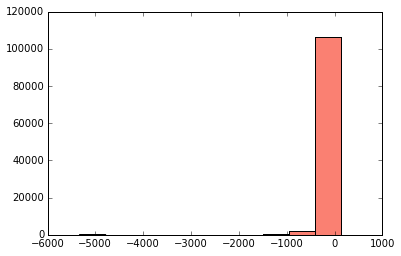

In [188]:
def residuals(features, y, model):
    #TODO - Write a function that calculates model residuals given input features, ground truth, and the model.
    residuals = model.predict(features) - y
    return residuals

#TODO - Plot the histogram of the residuals of your current model.
r = residuals(train_basic_features, train_basic_response, model)
r = r.plays.tolist()
pl.hist(r, histtype='bar', color='salmon')

See the structure in the plot? This means we've got more modeling to do before we can call it a day! It satisfies neither of our properties - we're often way wrong with our predictions, and seem to systematically **under** predict the number of plays a song will get.

What happens if we try and predict the $log$ of number of plays? This controls the exponential behaviour of plays, and gives less weight to the case where our prediction was off by 100 when the true answer was 1000. 

#### Exercise 10
**a.** Adapt your model fitting from above to fit the **log** of the nubmer of plays as your response variable. Print the scores.

In [183]:
from sklearn import linear_model

#TODO - Using what you built above, build a model using the log of the number of plays as the response variable.

temp = pd.DataFrame(log(train_basic_response.plays))

model_log = fit_model(train_basic_features, temp)


**b.** You should see a significantly better $R^2$ and validation $R^2$, though still pretty low. Take a look at the model residuals again, do they look any better?

(array([  1.30000000e+01,   7.30000000e+01,   3.48000000e+02,
          1.34600000e+03,   3.48300000e+03,   7.66100000e+03,
          1.40810000e+04,   2.54680000e+04,   3.90550000e+04,
          1.70090000e+04]),
 array([-4.40370072, -3.83393302, -3.26416533, -2.69439763, -2.12462993,
        -1.55486223, -0.98509453, -0.41532684,  0.15444086,  0.72420856,
         1.29397626]),
 <a list of 10 Patch objects>)

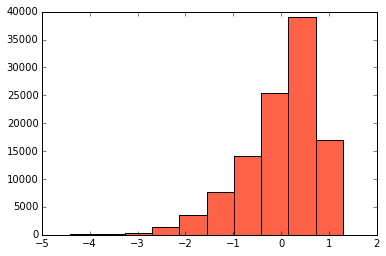

In [186]:
#TODO Plot residuals of your log model. Note - we want to see these on a "plays" scale, not a "log(plays)" scale!

r1 = residuals(train_basic_features, temp, model_log)
r1 = r1.plays.tolist()
pl.hist(r1, histtype='bar', color='tomato')

There must be something we can do here to build a better model. Let's try incorporating country and cluster information.

###2.3 Linear Modeling with Categorical Variables: One-Hot Encoding

Linear models expect **numbers** for input features. But we have some features that we think could be useful that are **discrete** or **categorical**. How do we represent these as numbers?

One solution is something called one-hot encoding. Basically, we map a discrete space to a vector of binary indicators, then use these indicators as numbers.

For example, if I had an input column that could take on the values {$RED$, $GREEN$, $BLUE$}, and I wanted to model this with one-hot-encoding, I could use a map:

* $RED = 001$
* $GREEN = 010$
* $BLUE = 100$

We use this representation instead of traditional binary numbers to keep these features independent of one another.

Once we've established this representation, we replace the columns in our dataset with their one-hot-encoded values. Then, we can fit a linear model on the data once it's encoded this way!

Statisticians and econometricians call these types of binary variables *dummy variables*, but we're going to call it one-hot encoding, because that sounds cooler.

Scikit-learn has functionality to transform values to this encoding built in, so we'll leverage that. The functionality is called `DictVectorizer` in scikit-learn. The idea is that you feed a `DictVectorizer` a bunch of examples of your data (that's the `vec.fit` line), and it builds a map from a categorical variable to a one-hot encoded vector like we have in the color example above. Then, you can use this object to translate from categorical values to sequences of numeric ones as we do with `vec.transform`. In the example below, we fit a vectorizer on the training data and use the same vectorizer on the validation data so that the mapping is consistent and we don't run into issues if the categories don't match perfectly between the two data sets.

####Exercise 11
**a.** Use the code below to generate new training and validation datasets for the datasets *with* the categorical features in them.

In [248]:
from sklearn import feature_extraction

def one_hot_dataframe(data, cols, vec=None):
    """ Takes a dataframe and a list of columns that need to be encoded.
        Returns a tuple comprising the data, and the fitted vectorizor.
        
        Based on https://gist.github.com/kljensen/5452382
    """
    if vec is None:
        vec = feature_extraction.DictVectorizer()
        vec.fit(data[cols].to_dict(orient='records'))
    
    vecData = pd.DataFrame(vec.transform(data[cols].to_dict(orient='records')).toarray())
    vecData.columns = vec.get_feature_names()
    vecData.index = data.index
    
    data = data.drop(cols, axis=1)
    data = data.join(vecData)
    return (data, vec)

def prep_dset(data, col, vec=None):
    #Convert the clusters to strings.
    new_data = data
    new_data['cluster'] = new_data['cluster'].apply(str)
    
    #Encode the data with OneHot Encoding.
    new_data, vec = one_hot_dataframe(new_data, ['country1','cluster'], vec)

    #Eliminate features we don't want to use in the model.
    badcols = ['country2','country3','artid','key','age']
    new_data = new_data.drop(badcols, axis=1)
    
    new_data = new_data.fillna(new_data.mean())
    
    return (new_data.drop([col], axis=1), pd.DataFrame(new_data[col]), vec)

[{'plays': '41'}, {'plays': '41'}, {'plays': '41'}, {'plays': '41'}, {'plays': '41'}, {'plays': '41'}, {'plays': '41'}, {'plays': '41'}, {'plays': '41'}, {'plays': '41'}, {'plays': '41'}, {'plays': '41'}, {'plays': '41'}, {'plays': '41'}, {'plays': '41'}]
[[ 1.]
 [ 1.]
 [ 1.]]
   0
0  1
1  1
2  1


In [253]:
# examples
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
D = [{'foo': 1, 'bar': 2}, {'foo': 3, 'baz': 1}]
X = v.fit_transform(D)
print(X)
v.inverse_transform(X) ==         [{'bar': 2.0, 'foo': 1.0}, {'baz': 1.0, 'foo': 3.0}]
v.transform({'foo': 4, 'unseen_feature': 3})

[[ 2.  0.  1.]
 [ 0.  1.  3.]]


array([[ 0.,  0.,  4.]])

In [285]:
random.seed(2015)
train_cats_features, train_cats_response, vec = prep_dset(train, 'plays')
validation_cats_features, validation_cats_response, _ = prep_dset(validation, 'plays', vec)

**b.** Now that you've added the categorical data, let's see how it works with a linear model!

In [286]:
random.seed(2015)
print (fit_model_and_score(train_cats_features, train_cats_response, validation_cats_features, validation_cats_response))

(1.0, -0.11644682392943184)


You should see a much better $R^2$ for the training data, but a much *worse* one for the validation data. What happened?

This is a phenomenon called **overfitting** - our model has too many degrees of freedom (one parameter for each of the 100+ features of this dataset. This means that while our model fits the training data reasonably well, but at the expense of being too specific to that data.

John Von Neumann famously said ["With four parameters I can fit an elephant, and with five I can make him wiggle his trunk!"](http://www.johndcook.com/blog/2011/06/21/how-to-fit-an-elephant/).

### 2.4 Non-linear modeling and Regression Trees
So, we're at an impasse. We didn't have enough features and our model performed poorly, we added too many features and our model looked good on training data, but not so good on test data.

What's a modeler to do? 

There are a couple of ways of dealing with this situation - one of them is called **regularization**, which you might try on your own (see `RidgeRegression` or `LassoRegression` in scikit-learn), another is to use a model which captures **non-linear** relationships between the features and the response variable.

One such type of model was pioneered here at Berkeley, by the late, great Leo Breiman. These models are called **regression trees**.

The basic idea behind regression treees is to recursively partition the dataset into subsets that are *similar with respect to the response variable*. 

If we take our temperature example, we might observe a non-linear relationship - electricity gets expensive when it's cold outside because we use the heater, but it also gets expensive when it's too hot outside because we run the air conditioning. 

A decision tree model might dynamically elect to split the data on the temperature feature, and estimate high prices both for hot and cold, with lower prices for more Berkeley-like temperatures. Go read the [scikit-learn decision trees documentation](http://scikit-learn.org/stable/modules/tree.html) for more background.

####Exercise 12
**a.** Using the scikit learn `DecsionTreeRegressor` API, write a function that fits trees with the parameter 'max_depth' exposed to the user, and set to 10 by default.

In [308]:
from sklearn import tree

def fit_tree(X, y, depth=10):
    ##TODO: Using the DecisionTreeRegressor, train a model to depth 10.
    regressor = tree.DecisionTreeRegressor(max_depth = depth)
    model = regressor.fit(X, y)
    return model

#regressor = tree.DecisionTreeRegressor(max_depth = 10)
#model = regressor.fit(train_cats_features, train_cats_response)
#print(model.score(train_cats_features, train_cats_response))
#print(model.score(validation_cats_features, validation_cats_response))

**b.** You should be able to use your same scoring function as above to compute your model scores. Write a function that fits a tree model to your training set and returns the model's score for both the training set and the validation set.

In [350]:
def fit_model_and_score_tree(train_features, train_response, val_features, val_response):
    ##TODO: Fit a tree model and report the score on both the training set and test set.
    model = fit_tree(train_features, train_response, 12)
    score1 = model.score(train_features, train_response)
    score2 = model.score(val_features, val_response)
    return score1, score2

**c.** Report the scores on the training and test data for both the basic features and the categorical features.

In [351]:
print (fit_model_and_score_tree(train_basic_features, train_basic_response, 
                                validation_basic_features, validation_basic_response))

print (fit_model_and_score_tree(train_cats_features, train_cats_response, 
                                validation_cats_features, validation_cats_response))

(0.4994202307304888, 0.12962069474711213)
(1.0, -0.11644682392943184)


Hooray - we've got a model that performs well on the training data set *and* the validation dataset. Which one is better? Why do you think that is. Try varying the depth of the decision tree (from, say, 2 to 20) and see how either data set does with respect to training and validation error. 

**d.** Now, let's build a tree to depth 3 and take a look at it.

In [358]:
from io import StringIO
#import StringIO
import pydot# I can't install pydot
from IPython.display import Image

tmodel = fit_tree(train_basic_features, train_basic_response, 3)

def display_tree(tmodel):
    #dot_data = StringIO.StringIO() 
    dot_data = StringIO()
    tree.export_graphviz(tmodel, out_file=dot_data) 
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())
    
display_tree(tmodel)

NameError: name 'pydot' is not defined

**e.** What is the tree doing? It looks like it's making a decision on variables X[4] and X[2] - can you briefly describe, in words, what the tree is doing?

>TODO: I can't see the tree. 

**f.** Finally, let's take a look at variable importance for a tree trained to 10 levels - this is a more formal way of deciding which features are important to the tree. The metric that scikit-learn calculates for feature importance is called GINI importance, and measures how much total 'impurity' is removed by splits from a given node. Variables that are highly discriminitive (e.g. ones that occur frequently throughout the tree) have higher GINI scores. You can read more about these scores [here](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#giniimp).

In [359]:
tmodel = fit_tree(train_basic_features, train_basic_response, 10)

pd.DataFrame(tmodel.feature_importances_, train_basic_features.columns)

,0
pctmale,0.117360
age,0.032428
pctgt1,0.420071
pctgt2,0.144822
pctgt5,0.247639
account_age,0.037680


**g.** What do you notice? Is the output interpretable? How would you explain this to someone?

>TODO: pctgt1, pctgt2, and pctgt5, which measure the percentage of plays that come from a user who has played the music 1, 2, and 5 times, explain the total number of plays more than the music's gender skew and age. 